# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to <b>determine which demographic groups respond best to which offer type</b>. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is <b>feeling the influence of the offer</b>for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)



**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [106]:
import pandas as pd
import numpy as np
import math
import json

import seaborn as sns
import matplotlib.pyplot as plt


# import matplotlib
%matplotlib inline



In [107]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Exploratory Data Analysis

### portfolio.json
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)



In [108]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [109]:
# coded the offer id
offer_code = {'ae264e3637204a6fb9bb56bc8210ddfd' : "A", 
              '4d5c57ea9a6940dd891ad53e9dbe8da0': "B", 
              '3f207df678b143eea3cee63160fa8bed': "C",
              '9b98b8c7a33c4b65b9aebfe6a799e6d9': "D",
              '0b1e1539f2cc45b7b9fa7c272da2e1d7' : "E",
              '2298d6c36e964ae4a3e7e9706d1fb8c2': "F",
              'fafdcd668e3743c1bb461111dcafc2a4':"G",
              '5a8bc65990b245e5a138643cd4eb9837': "H",
              'f19421c1d4aa40978ebb69ca19b0e20d':"I",
              '2906b810c7d4411798c6938adc9daaa5': "J"
             }



In [110]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


- The data types have been properly coded
- The portfolio rewards are all unique

In [111]:
portfolio.shape

(10, 6)

In [112]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [113]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [114]:
#rename column name
portfolio.rename({'id': 'offer_id'}, axis =1, inplace=True)

In [115]:
portfolio

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [116]:
#for the channels column, spread each category into a different column - one hot encode
dummy_channels = pd.get_dummies(portfolio['channels'].apply(pd.Series).stack()).sum(level=0)  #dealing with list
portfolio = pd.concat([portfolio, dummy_channels], axis=1)

#drop channel;s col
portfolio.drop(columns = ['channels'], inplace= True)

In [117]:
#function to get dummy variables from a particular categorical column

In [118]:
portfolio 

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


In [119]:
port_cat = ["reward", "duration", "offer_type", "difficulty"]

In [120]:
for i in port_cat:
    print (i, '=',  portfolio[i].unique())

reward = [10  0  5  3  2]
duration = [ 7  5  4 10  3]
offer_type = ['bogo' 'informational' 'discount']
difficulty = [10  0  5 20  7]


In [121]:
len(portfolio['offer_id'].unique())


10

In [122]:
def count_plot(df, catcols):
    """
        count plots for categorical data
        input: dataframe and list of categorical columns to plot a countplot for
        Output: plot
    """
    for col in catcols:
        sns.countplot(x= df[col], data=df, palette='Greens');
        plt.show()
        

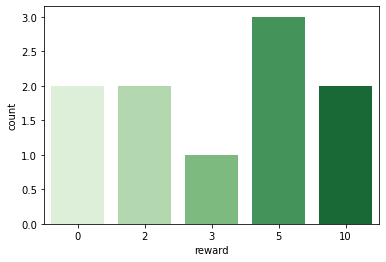

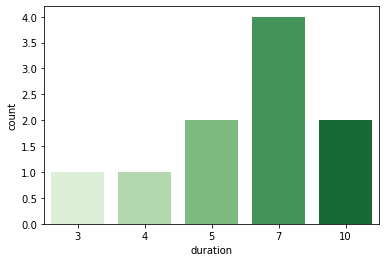

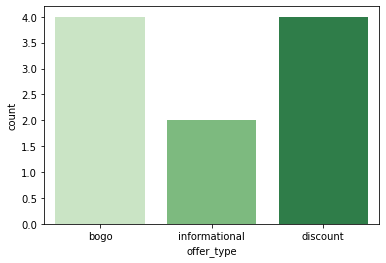

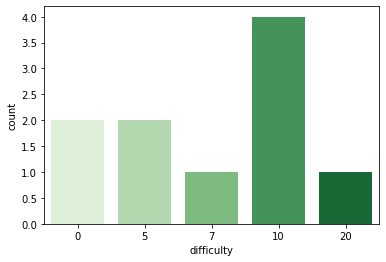

In [123]:
count_plot(df=portfolio, catcols = port_cat)

In [124]:
portfolio["offer_id"] = portfolio["offer_id"].replace(offer_code)

## profile.json
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [125]:
profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [126]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [127]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [128]:
prof_cat = ['gender'] 
prof_num = ['age', 'income']

In [129]:
#percentages of categories
for i in prof_cat:
    print( profile[i].value_counts()*100/len(profile[i]))
    

M    49.905882
F    36.052941
O     1.247059
Name: gender, dtype: float64


In [130]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

- some gender has been coded none and O. 
- Missing data _incme and gender. 
- the datatype for date is not proper.We turn to datetime
- max age 118 must be an outlier,we check

In [131]:
def dist_plot(df, numcols, hist):
    """
        plot a distribution plot with or without histograms
        input: 
            df: df
            numcols: list of numerical columns
            hist: Boolean for whether you want histograms with it. 
    """

    for col in numcols:
        sns.distplot(df[col],hist=hist)
        plt.title("Distribution of "+ col)
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.show()
        

/Users/oladipooluwadamilola/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


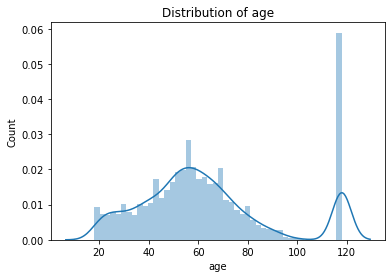

In [132]:
dist_plot(df=profile, numcols=['age'], hist = True )

In [133]:
# specific count of profiles exactly of age = 118 and check the subset where age is 118 for the other columns
profile[profile['age']==118].count()

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64

In [134]:
#change datatype for became_member on column
#first, convert col to string then df
profile['became_member_on'] = profile['became_member_on'].apply(str)

profile['became_member_on'] =  pd.to_datetime(profile['became_member_on'], infer_datetime_format=True)

profile['became_member_on'].dtype

dtype('<M8[ns]')

In [135]:
#Find how long they have been members in years

#find the earliest and latest membership dates
print(min(profile['became_member_on']), "\n", 
      max(profile['became_member_on']))

2013-07-29 00:00:00 
 2018-07-26 00:00:00


In [136]:
#I am assuming this data was collected in year 2019
profile['member_since_yrs'] = (2019 - profile["became_member_on"].dt.year).apply(int)
profile['member_since_yrs'].dtype

dtype('int64')

In [137]:
#remove the membershp date col
profile.drop(columns = ['became_member_on'], inplace= True)

In [138]:
profile

,gender,age,id,income,member_since_yrs
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,NaN,2
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,NaN,1
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2
4,None,118,a03223e636434f42ac4c3df47e8bac43,NaN,2
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,54000.0,1
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,72000.0,1
16997,M,49,01d26f638c274aa0b965d24cefe3183f,73000.0,2
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,50000.0,3


In [139]:
profile['member_since_yrs'].value_counts()*100/len(profile['member_since_yrs'])
# len(profile['gender'])

2    38.052941
1    24.694118
3    20.741176
4    10.764706
5     4.064706
6     1.682353
Name: member_since_yrs, dtype: float64

In [140]:
#rename column title
profile.rename({'id': 'customer_id'}, axis =1, inplace=True)

In [141]:
#Finding Duplicates
print("No of unique records in the df (given by report_number) is {}".format(profile['customer_id'].
                                                                                nunique()))

No of unique records in the df (given by report_number) is 17000


#### Dealing with missing data and outliers
It seems that people whose gender and income are missing also have age of 118 years. 
These are probably persons who fill the info forms mindlessly and do not really wish to share info

In [142]:
subdf_118 = profile[['age','gender','income']][profile['age']==118]
                    
subdf_118

,age,gender,income
0,118,None,NaN
2,118,None,NaN
4,118,None,NaN
6,118,None,NaN
7,118,None,NaN
...,...,...,...
16980,118,None,NaN
16982,118,None,NaN
16989,118,None,NaN
16991,118,None,NaN


In [143]:
#CONFIRM no of nulls 
subdf_118.isnull().sum()

#WE SEE THAT TRULY ALL THE ENTRIES FOR GENDER AND INCOME ARE ENTIRELY MISSING WHEN THE AGE IS 118. NOWHERE ELSE.

age          0
gender    2175
income    2175
dtype: int64

In [144]:
2175*100/14825

14.671163575042158

APPROACH 1: This is about 15% of our dataset. We may remove them. To remove these customers, first merge the profile df to the sales df and then remove accordingly. (we dont want to have sales with no/deleted customer id related to them) OR just mer

APPROACH2 : Put the missing gender values into a new category called "Unknown". Visualise class separation of our label(to-do in next transcript df) to see if these label classes are well separated by gender_unknown. If no obvious relationship, We may merge with the other category called "O" to avoid complexity in our model(ie too many feature categories)

In [145]:
#countplot(df=profile, catcols = pro_cat)

In [146]:
#Remove customers with age 118
# profile = profile[profile['age'] != 118]

In [147]:
profile

,gender,age,customer_id,income,member_since_yrs
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,NaN,2
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,NaN,1
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2
4,None,118,a03223e636434f42ac4c3df47e8bac43,NaN,2
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,54000.0,1
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,72000.0,1
16997,M,49,01d26f638c274aa0b965d24cefe3183f,73000.0,2
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,50000.0,3


In [148]:
prof_cat = ['gender', 'member_since_yrs'] 
prof_num = ['age', 'income']

/Users/oladipooluwadamilola/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


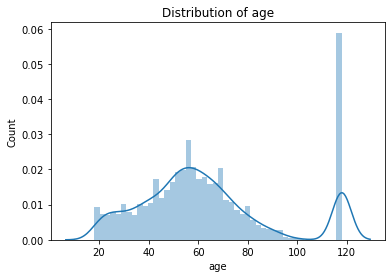

/Users/oladipooluwadamilola/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


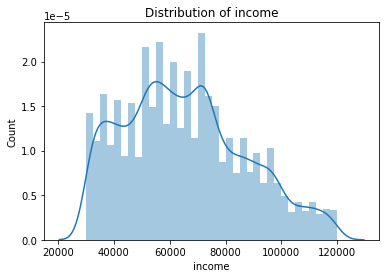

In [149]:
dist_plot(df=profile, numcols=prof_num, hist= True)

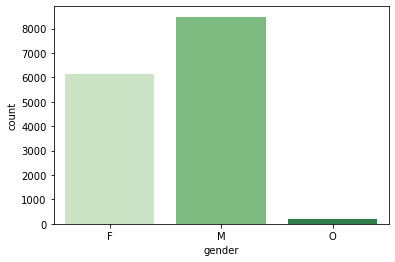

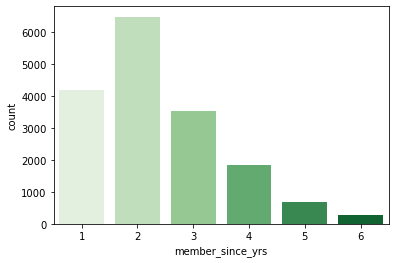

In [150]:
count_plot(df=profile, catcols=prof_cat)

## Transcript


**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [151]:
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [152]:
transcript.rename({'person': 'customer_id'}, axis =1, inplace=True)

In [153]:
#change sales time from hours to days: and of course, rename it as appropriate

transcript['time'] = (transcript['time'] / 24) .apply(lambda x: math.ceil(x))
transcript['time'].replace(0, 1, inplace=True)   #replace days calculated to be  0 with 1

In [154]:
transcript.rename({'time': 'day'}, axis =1, inplace=True)

In [155]:
#one hot encode the event column
dummy_event = pd.get_dummies(transcript['event'])
transcript = pd.concat([transcript, dummy_event], axis=1)


#drop  col
# transcript.drop(columns = ['event'], inplace= True)

In [156]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [157]:
#------------------------------------------------------------------------------------------------
#values column_  extract the values from the dictionary
# transcript['value_trans'] = transcript['value'].apply(lambda x: list(x.values())[0]) 
#!inconsistent datatype !


In [158]:
transcript.iloc[199000:200000]

,customer_id,event,value,day,offer completed,offer received,offer viewed,transaction
199000,8c54f6657313449b9f78e1f6b7a17aa9,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,21,1,0,0,0
199001,c34b2bbea66543e6959258063efe9fbc,transaction,{'amount': 4.67},21,0,0,0,1
199002,4744cfa970244d629b0a279fd2a468b2,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},21,0,0,1,0
199003,bb6e1c4b0c814c0d95fefd429c608295,transaction,{'amount': 3.42},21,0,0,0,1
199004,10af934bbfb641a49d9376d61dcb203a,transaction,{'amount': 21.82},21,0,0,0,1
...,...,...,...,...,...,...,...,...
199995,78bdca4288884249b71accd31a69b9d3,transaction,{'amount': 1.4},21,0,0,0,1
199996,be983f80dcbd4bafa18794dbd103553b,transaction,{'amount': 2.34},21,0,0,0,1
199997,1f6ad0a8def240b3ad633f83032dedd8,transaction,{'amount': 3.26},21,0,0,0,1
199998,f093e47717a7481786d016b1fe56d1ad,transaction,{'amount': 1.18},21,0,0,0,1


In [159]:

#new column to store only amount, extracted from value column dictionaries

transcript['amount'] = transcript['value'].apply(lambda x: x['amount'] if 'amount' in x else None)


#new col to store  offer_id only, extracted from value column. This store all the offers that were involved n sale
transcript['offer_id'] = transcript['value'].apply(lambda x: x['offer id'] if 'offer id' in x else (x['offer_id'] \
                                                                if 'offer_id' in x else None))




In [160]:
transcript['reward'] = transcript['value'].apply(lambda x:x['reward'] if 'reward' in x else None)


In [161]:
#recode offerid for better readability
transcript['offer_id'] = transcript['offer_id'].replace(offer_code)

From this new col offer_id, we can find the unique offers and relate them to the events(when they were received, opened or completed )through the event columnn; for each customer. 

In [162]:
transcript['event'].value_counts()/len(transcript)

transaction        0.453304
offer received     0.248837
offer viewed       0.188315
offer completed    0.109544
Name: event, dtype: float64

In [163]:
d= transcript[transcript['event']== 'offer completed']
list(d.value)[2]
#Apparently, When offer is completed, there is another kv pair under column value, called reward

{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}

#So, there are two kinds of people who completed offer:

Offer completed = received + viewed  --------> Sales might be influenced by offer (1)

            OR
            
Offer completed = received + Not viewed -------> Sales not influenced by offer (0)



The difference with these group of people = viewing. This is the column we shall use to identify the influence of the offers.



 v-------------------------------------------------------------------------------
 
Note: transaction events did not receive offer at all. Just normal sales.
#For now, we shall not consider these rows. drop.

In [164]:
offers_only = transcript[transcript['event'] != 'transaction']

In [165]:
offers_only

,customer_id,event,value,day,offer completed,offer received,offer viewed,transaction,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},1,0,1,0,0,NaN,D,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},1,0,1,0,0,NaN,E,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},1,0,1,0,0,NaN,J,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},1,0,1,0,0,NaN,G,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},1,0,1,0,0,NaN,B,NaN
...,...,...,...,...,...,...,...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,30,1,0,0,0,NaN,F,3.0
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,30,1,0,0,0,NaN,G,2.0
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,offer viewed,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},30,0,0,1,0,NaN,E,NaN
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,30,1,0,0,0,NaN,G,2.0


#### Deal with missing values

Fill missing values caused by transformation and encodings with 0

In [166]:
offers_only=offers_only.fillna(0)

### Influenced or Not?
Now we try to classify these sales based on whether they were influenced by the offers or not.

if the customers sales were influenced by the adverts and offers ___YES (1)

if the customers were not influenced by the adverts and offers ____No(0)


    

In [167]:
offers_only =offers_only.groupby(['customer_id', 'offer_id', 'event'])['customer_id'].count().unstack()

In [168]:
offers_only=offers_only.reset_index(level=[0,1])  #?

In [169]:
offers_only = offers_only.fillna(0)
offers_only

event,customer_id,offer_id,offer completed,offer received,offer viewed
0,0009655768c64bdeb2e877511632db8f,C,0.0,1.0,1.0
1,0009655768c64bdeb2e877511632db8f,G,1.0,1.0,1.0
2,0009655768c64bdeb2e877511632db8f,H,0.0,1.0,1.0
3,0009655768c64bdeb2e877511632db8f,I,1.0,1.0,1.0
4,0009655768c64bdeb2e877511632db8f,J,1.0,1.0,0.0
...,...,...,...,...,...
63283,fffad4f4828548d1b5583907f2e9906b,I,2.0,2.0,2.0
63284,ffff82501cea40309d5fdd7edcca4a07,D,1.0,1.0,1.0
63285,ffff82501cea40309d5fdd7edcca4a07,E,1.0,1.0,1.0
63286,ffff82501cea40309d5fdd7edcca4a07,G,1.0,1.0,1.0



received  | view   | complete  | influence

1-------------1------ ----1 ----------1

1--------- ---0-----------0-----------0

1------------0------------1 ----------0

1------------1-------------0-----------0


Thus,

if (offer viewed * offer completed) != 0, then Influence =1

if (offer viewed * offer completed) =0, then Influence = 0


In [170]:
offers_only['influenced'] = (offers_only['offer viewed'] * offers_only['offer completed'])\
                            .apply(lambda x: 1 if x != 0 else 0)

offers_only.drop(['offer completed','offer viewed','offer received'],axis=1, inplace = True)

In [171]:
#Merge all dataset keeping all offered sales 

all_df_offered = offers_only.merge(profile, how='left', on='customer_id')
all_df_offered = all_df_offered.merge(portfolio, how='left', on='offer_id')

In [172]:
2*8

16

In [173]:
all_df_offered

,customer_id,offer_id,influenced,gender,age,income,member_since_yrs,reward,difficulty,duration,offer_type,email,mobile,social,web
0,0009655768c64bdeb2e877511632db8f,C,0,M,33,72000.0,2,0,0,4,informational,1,1,0,1
1,0009655768c64bdeb2e877511632db8f,G,1,M,33,72000.0,2,2,10,10,discount,1,1,1,1
2,0009655768c64bdeb2e877511632db8f,H,0,M,33,72000.0,2,0,0,3,informational,1,1,1,0
3,0009655768c64bdeb2e877511632db8f,I,1,M,33,72000.0,2,5,5,5,bogo,1,1,1,1
4,0009655768c64bdeb2e877511632db8f,J,0,M,33,72000.0,2,2,10,7,discount,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63283,fffad4f4828548d1b5583907f2e9906b,I,1,M,34,34000.0,2,5,5,5,bogo,1,1,1,1
63284,ffff82501cea40309d5fdd7edcca4a07,D,1,F,45,62000.0,3,5,5,7,bogo,1,1,0,1
63285,ffff82501cea40309d5fdd7edcca4a07,E,1,F,45,62000.0,3,5,20,10,discount,1,0,0,1
63286,ffff82501cea40309d5fdd7edcca4a07,G,1,F,45,62000.0,3,2,10,10,discount,1,1,1,1


## Visualisations 

In [174]:
all_df_offered.isnull().sum()

customer_id            0
offer_id               0
influenced             0
gender              8066
age                    0
income              8066
member_since_yrs       0
reward                 0
difficulty             0
duration               0
offer_type             0
email                  0
mobile                 0
social                 0
web                    0
dtype: int64

In [175]:
all_df_offered['customer_id'].nunique()

16994

In [176]:
all_df_offered.nunique()

customer_id         16994
offer_id               10
influenced              2
gender                  3
age                    85
income                 91
member_since_yrs        6
reward                  5
difficulty              5
duration                5
offer_type              3
email                   1
mobile                  2
social                  2
web                     2
dtype: int64

In [177]:
2175/16994

0.12798634812286688

In [178]:
#removing age and income we will be loosing about 12% of our unique customers/dataset
#First Try: Delete the missing rows and model the data. We will do this.
#second try: fill missing values depending on factors. later

In [179]:
##thus, Remove customers with age 118
all_df_offered= all_df_offered[all_df_offered['age'] != 118]

In [180]:
all_df_offered.isnull().sum()

customer_id         0
offer_id            0
influenced          0
gender              0
age                 0
income              0
member_since_yrs    0
reward              0
difficulty          0
duration            0
offer_type          0
email               0
mobile              0
social              0
web                 0
dtype: int64

In [181]:
num_cols =['age', 'income']

cat_cols = ['offer_id', 'reward', 'influenced', 'gender', 'member_since_yrs', 'difficulty', 'duration','email',\
           
           'offer_type', 'mobile', 'social', 'web']


/Users/oladipooluwadamilola/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


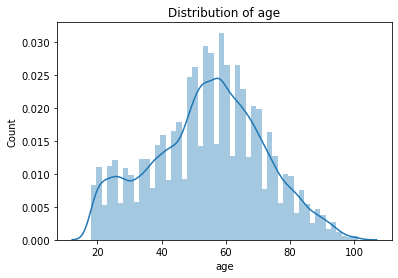

/Users/oladipooluwadamilola/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


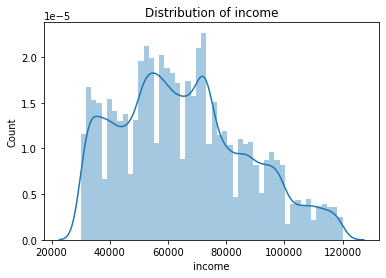

In [182]:
#Simple distribution plot for num cols
dist_plot(df=all_df_offered, numcols= num_cols, hist=True)

The distributions are fairly normally distributed.

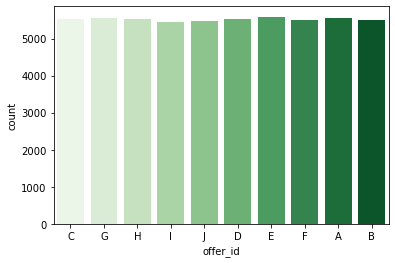

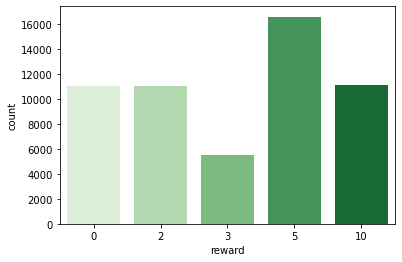

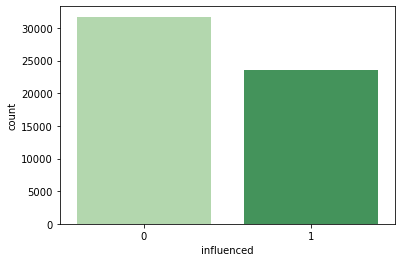

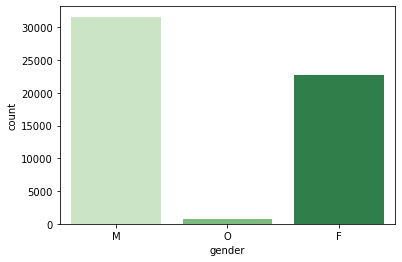

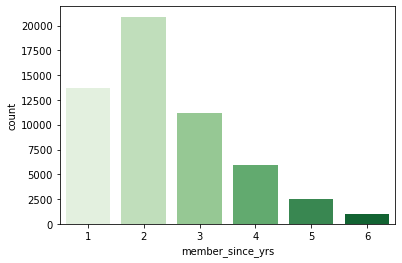

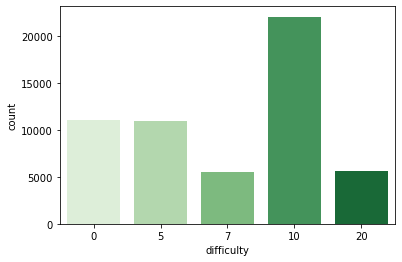

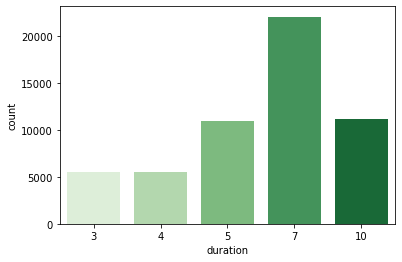

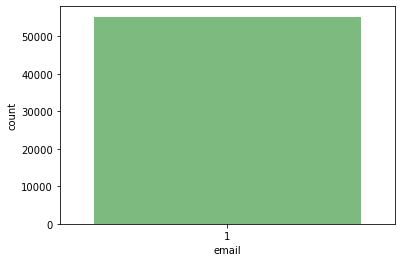

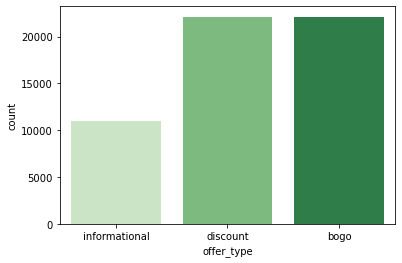

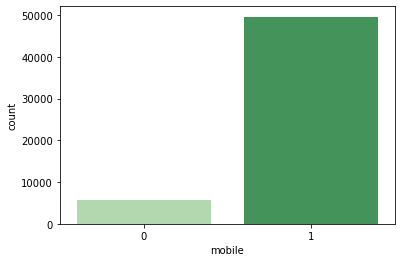

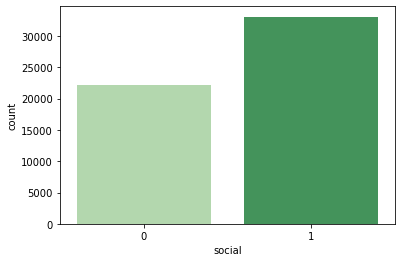

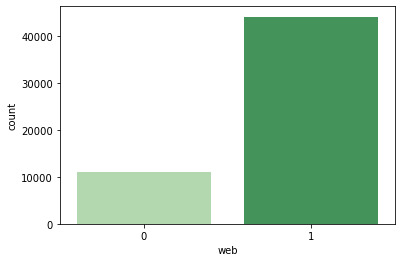

In [183]:
#Simple distribution plot for num cols
count_plot(df=all_df_offered, catcols= cat_cols)

the offer types are evenly distributed in the dataset.

There isnt much class imbalance in our label.

Gender O is very minor compared to the rest, we can merge the category O to the average gender based on class separation(a boxplot can reveal to us a goood way to merge this categry)

There is no variability in column 'email'. it can be removed.

In [184]:
all_df_offered.drop(['email'],axis=1, inplace = True)

/Users/oladipooluwadamilola/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


/Users/oladipooluwadamilola/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='gender', ylabel='income'>

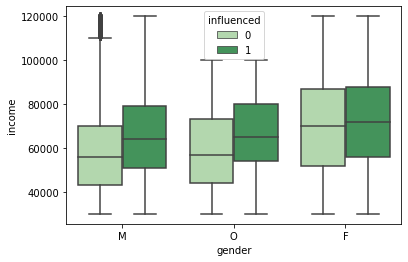

In [185]:
sns.boxplot(all_df_offered['gender'], all_df_offered['income'], palette="Greens",\
            hue=all_df_offered['influenced'])

Generally, for all gender, people who earn more are more influenced by offers. However, This is less obvious for females.

/Users/oladipooluwadamilola/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Count of Offer Type based on its influence')

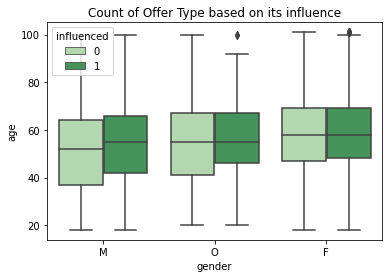

In [186]:
sns.boxplot(all_df_offered['gender'], all_df_offered['age'], palette="Greens",\
            hue=all_df_offered['influenced'])

#plt.legend(['Uninfluenced','Influenced'],frameon=False)
plt.title('Count of Offer Type based on its influence')

For females and Os,  the age  doesnt seem to have causes on influence.
However, for men, older men on average are  a little likely to be influenced to buy

Text(0.5, 1.0, 'Count of Offer Type based on its influence')

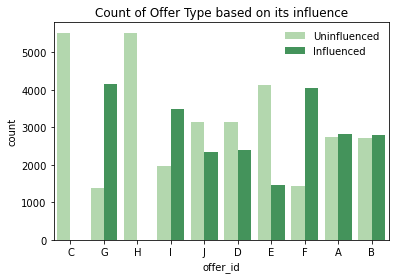

In [187]:
sns.countplot(x='offer_id',hue='influenced',data=all_df_offered, palette='Greens');
plt.legend(['Uninfluenced','Influenced'],frameon=False)
plt.title('Count of Offer Type based on its influence')

#plt.xticks(rotation=45);

We see that offers C and H had no influence at all. People are not buying into it?.
G, F and I are the most viewed and completed offer types.
A and B don't really have much variability.

In [188]:
#combine categories
all_df_offered['offer_id']= all_df_offered['offer_id'].replace("C", "H")
all_df_offered['offer_id']= all_df_offered['offer_id'].replace(["F", 'G'], "I")
all_df_offered['offer_id']= all_df_offered['offer_id'].replace("B", "A")
all_df_offered['offer_id']= all_df_offered['offer_id'].replace(["J","D"], "E")


<ipython-input-188-bdfea9186466>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_df_offered['offer_id']= all_df_offered['offer_id'].replace("C", "H")
<ipython-input-188-bdfea9186466>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_df_offered['offer_id']= all_df_offered['offer_id'].replace(["F", 'G'], "I")
<ipython-input-188-bdfea9186466>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [189]:
all_df_offered['gender']= all_df_offered['gender'].replace("O", "F")

<ipython-input-189-e1d5c526b705>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_df_offered['gender']= all_df_offered['gender'].replace("O", "F")


Text(0.5, 1.0, 'Count of gender based on its influence')

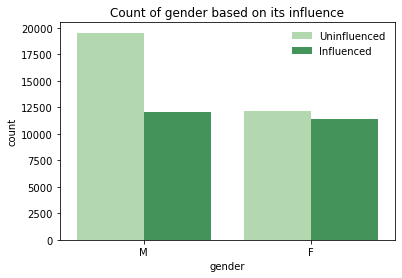

In [190]:
sns.countplot(x='gender',hue='influenced',data=all_df_offered, palette='Greens');
plt.legend(['Uninfluenced','Influenced'],frameon=False)
plt.title('Count of gender based on its influence')

Text(0.5, 1.0, 'Count of Offer Type bsased on influence')

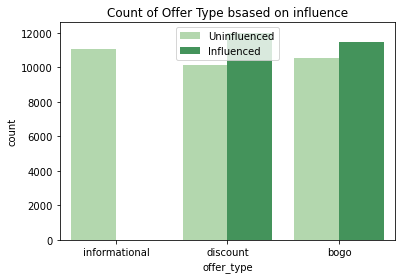

In [191]:
sns.countplot(x='offer_type',hue='influenced',data=all_df_offered, palette='Greens');
plt.legend(['Uninfluenced','Influenced'],frameon=True)
plt.title('Count of Offer Type bsased on influence')

Informational offers are not  successful 

Text(0.5, 1.0, 'Count based on membership duration')

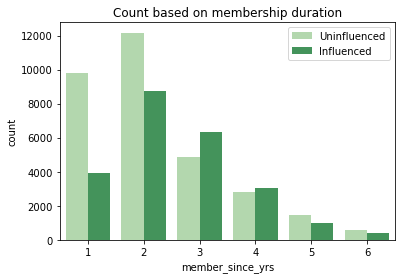

In [192]:
sns.countplot(x='member_since_yrs',hue='influenced',data=all_df_offered, palette='Greens');
plt.legend(['Uninfluenced','Influenced'],frameon=True)
plt.title('Count based on membership duration')

In [88]:

# # scatter plot matrix
# from pandas.plotting import scatter_matrix

# scatter_matrix(all_df_offered[''])
# plt.show()

In [225]:
## Data Preparation for Modelling

from sklearn.pipeline import Pipeline

from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report,f1_score
# from sklearn.metrics import roc_auc_score,roc_curve, auc
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV

In [226]:
all_df_offered

,customer_id,offer_id,influenced,gender,age,income,member_since_yrs,reward,difficulty,duration,offer_type,mobile,social,web
0,0009655768c64bdeb2e877511632db8f,H,0,M,33,72000.0,2,0,0,4,informational,1,0,1
1,0009655768c64bdeb2e877511632db8f,I,1,M,33,72000.0,2,2,10,10,discount,1,1,1
2,0009655768c64bdeb2e877511632db8f,H,0,M,33,72000.0,2,0,0,3,informational,1,1,0
3,0009655768c64bdeb2e877511632db8f,I,1,M,33,72000.0,2,5,5,5,bogo,1,1,1
4,0009655768c64bdeb2e877511632db8f,E,0,M,33,72000.0,2,2,10,7,discount,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63283,fffad4f4828548d1b5583907f2e9906b,I,1,M,34,34000.0,2,5,5,5,bogo,1,1,1
63284,ffff82501cea40309d5fdd7edcca4a07,E,1,F,45,62000.0,3,5,5,7,bogo,1,0,1
63285,ffff82501cea40309d5fdd7edcca4a07,E,1,F,45,62000.0,3,5,20,10,discount,0,0,1
63286,ffff82501cea40309d5fdd7edcca4a07,I,1,F,45,62000.0,3,2,10,10,discount,1,1,1


In [227]:
dummy_id = pd.get_dummies(all_df_offered.offer_id)
dummy_type = pd.get_dummies(all_df_offered.offer_type)
dummy_gen = pd.get_dummies(all_df_offered.gender)

In [228]:
all_df_offered = pd.concat([all_df_offered, dummy_id],  axis=1)

In [229]:
all_df_offered = pd.concat([all_df_offered, dummy_type],  axis=1)
all_df_offered = pd.concat([all_df_offered, dummy_gen],  axis=1)
all_df_offered.drop(columns = ['offer_id', 'offer_type', 'customer_id','gender'], inplace= True)

In [230]:
all_df_offered

,influenced,age,income,member_since_yrs,reward,difficulty,duration,mobile,social,web,A,E,H,I,bogo,discount,informational,F,M
0,0,33,72000.0,2,0,0,4,1,0,1,0,0,1,0,0,0,1,0,1
1,1,33,72000.0,2,2,10,10,1,1,1,0,0,0,1,0,1,0,0,1
2,0,33,72000.0,2,0,0,3,1,1,0,0,0,1,0,0,0,1,0,1
3,1,33,72000.0,2,5,5,5,1,1,1,0,0,0,1,1,0,0,0,1
4,0,33,72000.0,2,2,10,7,1,0,1,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63283,1,34,34000.0,2,5,5,5,1,1,1,0,0,0,1,1,0,0,0,1
63284,1,45,62000.0,3,5,5,7,1,0,1,0,1,0,0,1,0,0,1,0
63285,1,45,62000.0,3,5,20,10,0,0,1,0,1,0,0,0,1,0,1,0
63286,1,45,62000.0,3,2,10,10,1,1,1,0,0,0,1,0,1,0,1,0


In [231]:
#move Y to end
cols = list(all_df_offered.columns.values) #Make a list of all of the columns in the df
cols.pop(cols.index('influenced')) #Remove Y from list
df = all_df_offered[cols+['influenced']] #Create new dataframe with columns in the order

In [232]:
df

,age,income,member_since_yrs,reward,difficulty,duration,mobile,social,web,A,E,H,I,bogo,discount,informational,F,M,influenced
0,33,72000.0,2,0,0,4,1,0,1,0,0,1,0,0,0,1,0,1,0
1,33,72000.0,2,2,10,10,1,1,1,0,0,0,1,0,1,0,0,1,1
2,33,72000.0,2,0,0,3,1,1,0,0,0,1,0,0,0,1,0,1,0
3,33,72000.0,2,5,5,5,1,1,1,0,0,0,1,1,0,0,0,1,1
4,33,72000.0,2,2,10,7,1,0,1,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63283,34,34000.0,2,5,5,5,1,1,1,0,0,0,1,1,0,0,0,1,1
63284,45,62000.0,3,5,5,7,1,0,1,0,1,0,0,1,0,0,1,0,1
63285,45,62000.0,3,5,20,10,0,0,1,0,1,0,0,0,1,0,1,0,1
63286,45,62000.0,3,2,10,10,1,1,1,0,0,0,1,0,1,0,1,0,1


In [233]:
Y = df.influenced.values #label
X = df.iloc[:, :18].values #features

In [234]:
X.shape, Y.shape

((55222, 18), (55222,))

In [235]:
#train test split

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=.25,random_state=55)


In [236]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((41416, 18), (13806, 18), (41416,), (13806,))

In [237]:
#standardize numerical features
#Feature scaling
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [238]:
X_train.shape, X_test.shape

((41416, 18), (13806, 18))

## Modelling

In [239]:
#Logistics Regression 
model = LogisticRegression(solver='liblinear',random_state=42)

model.fit(X_train,y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [240]:
#predict
y_pred = model.predict(X_test)

#Model Evaluation
log_accuracy = accuracy_score(y_test,y_pred)
# log_f1_score = f1_score(y_test,log_pred)

# #
print("LogisticReg Accuracy")
print(accuracy_score(y_test, y_pred))



# print('Logisitic Regression F1 Score:')
# print(log_f1_score)

LogisticReg Accuracy
0.7360567869042446


Text(0.5, 15.0, 'Predicted')

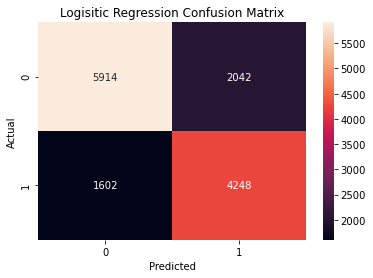

In [242]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d')
plt.title('Logisitic Regression Confusion Matrix')
plt.ylabel("Actual")
plt.xlabel("Predicted")

In [243]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.74      0.76      7956
           1       0.68      0.73      0.70      5850

    accuracy                           0.74     13806
   macro avg       0.73      0.73      0.73     13806
weighted avg       0.74      0.74      0.74     13806



In [244]:
#Improving Model
#hyperparameter tuning using Gridsearch


parameters = {'penalty': ['l1','l2'], 'C': [1,10,100]}

grid_log = GridSearchCV(LogisticRegression(), parameters, verbose=3, n_jobs=-1,cv=3)


In [245]:
grid_log.fit(X_train,y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Users/oladipooluwadamilola/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.73546449        nan 0.73548864        nan 0.7354645 ]
  warnings.warn(


GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1, 10, 100], 'penalty': ['l1', 'l2']},
             verbose=3)

In [246]:
grid_log.best_params_


{'C': 10, 'penalty': 'l2'}

In [247]:
log2_pred = grid_log.predict(X_test)
log2_accuracy = accuracy_score(y_test,log2_pred)
log2_f1 = f1_score(y_test,log2_pred)
print('Tuned Logistic Regression accuracy')
print(log2_accuracy)

print('Tuned Logistic Regression F1 score:') 
print(log2_f1)

Tuned Logistic Regression accuracy
0.7356221932493119
Tuned Logistic Regression F1 score:
0.7006724618664918


In [248]:
#the logistics model did not improve with tuninig. We may vary more parameters......

In [249]:
#Support Vector Machines
X_train, X_test, y_train, y_test = train_test_split(X,Y,random_state=42, test_size=.2)

#Feature scaling
scaler = StandardScaler()

X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)



svc = SVC()

#Train model
svc.fit(X_train,y_train)

#Predict values from test dataset
svc_y_pred = svc.predict(X_test)

#Evaluate accuracy and f1 score
svc_accuracy = accuracy_score(y_test,svc_y_pred)
svc_f1 = f1_score(y_test,svc_y_pred)

print(classification_report(y_test, svc_y_pred))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79      6363
           1       0.71      0.71      0.71      4682

    accuracy                           0.76     11045
   macro avg       0.75      0.75      0.75     11045
weighted avg       0.76      0.76      0.76     11045



In [250]:
print(svc_accuracy)
print(svc_f1)

0.7569035762788592
0.7121878014792582


In [251]:
#Accuracy and F1 score have only improved a little
#tune parameters

svc_model = SVC(C=1,gamma=1,kernel='rbf')

svc_model.fit(X_train,y_train)

y_pred_svc2 = svc_model.predict(X_test)


In [252]:
svc2_accuracy = accuracy_score(y_test,y_pred_svc2)
svc2_f1 = f1_score(y_test,y_pred_svc2)

In [253]:
# print('Accuracy')
# print(svc2_accuracy)
# print('F1 score' )
# print(svc2_f1)


print(classification_report(y_test, y_pred_svc2))

              precision    recall  f1-score   support

           0       0.79      0.80      0.79      6363
           1       0.72      0.70      0.71      4682

    accuracy                           0.76     11045
   macro avg       0.75      0.75      0.75     11045
weighted avg       0.76      0.76      0.76     11045



There is a little improvement, but not too much.

We may perform checks for feature importance. So as to use only the features with the most predictive power. We can also use other algorithms.

The machine learning process is iterative. We have to keep on trying new methods and manipulations until we reach our desired goals. This is an ongoing process..

To be continued......